# LSTM in TensorFlow: IMDb Sentiment Classification

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import layers, Input, Model

Unter MacOS mit Apple Silicon-Prozessor (M1, M2, M3) funktionieren LSTM und andere rekurrente Netze leider noch immer nicht, wenn sie mit Maskierung kombiniert werden. Daher müssen wir auf dieser Hardware-Platform die GPU deaktivieren und nur mit der CPU trainieren.

In [2]:
import platform
if platform.system() == "Darwin" and platform.processor() == "arm":
    print("Disabling GPU on MacOS M1/M2/M3 platform.")
    tf.config.experimental.set_visible_devices([], 'GPU')

Disabling GPU on MacOS M1/M2/M3 platform.


## Datensatz & Vorverarbeitung

In dieser Übung beschäftigen wir uns zum ersten Mal mit rekurrenten neuronalen Netzen (insb. LSTM) für sequentielle Daten am Beispiel der Textklassifikation. Ein sehr bekannter Datensatz zur Sentimentanalyse von [IMDb movie reviews](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data) ist bereits in TensorFlow enthalten. 

In [3]:
(text_train, y_train), (text_test, y_test) = imdb.load_data(num_words=10000, seed=4242)
print(len(text_train), 'training items')
print(len(text_test), 'test items')

25000 training items
25000 test items


Trainings- und Testdaten umfassen jeweils 25.000 Rezensionen, die als _positiv_ (1) oder _negativ_ (0) klassifiziert sind (was leider in der Dokumentation nicht erwähnt wird).

In [4]:
print(np.vstack(np.unique(y_train, return_counts=True)))

[[    0     1]
 [12500 12500]]


Die Texte sind bereits in der für Deep Learning benötigten Form aufbereitet und liegen jeweils als Listen von ganzzahligen Lexikon-IDs vor (auch wenn die Dokumentation leider von _unique tokens_ statt von _types_ spricht). Wir haben beim Laden des Datensatzes bereits das Vokabular auf die 10.000 häufigsten Wörter eingeschränkt. In einer realen Anwendung müssten wir natürlich die Texte zunächst tokenisieren und in diese numerische Darstellung überführen, was am bequemsten mit einem [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)-Layer erreicht werden kann.

In [5]:
print(text_train[0])

[1, 146, 685, 15, 7357, 37, 1040, 4, 22, 421, 4, 359, 8, 361, 38, 76, 5401, 18, 57, 282, 1689, 279, 198, 27, 326, 7, 1158, 108, 958, 7, 1606, 715, 19, 3868, 486, 1376, 11, 13, 197, 128, 7, 90, 5, 104, 329, 7, 90, 18, 14, 20, 10, 10, 2, 116, 5, 49, 388, 7, 486, 17, 73, 17, 49, 869, 674, 1326, 26, 51, 93, 72, 202, 12, 141, 6, 312, 675, 10, 10, 14, 238, 30, 6, 52, 20, 18, 1158, 476, 8, 106, 5, 462, 120, 44, 68, 205, 1588, 5, 68, 2, 21, 4, 583, 7, 6783, 18, 311, 2166, 615, 2, 51, 100, 28, 77, 6, 223, 22, 21, 996, 434, 24, 290, 3427, 278, 23, 151, 12, 238, 30, 290, 6, 106, 18, 879, 23, 699]


Die Lexikon-IDs sind nach Häufigkeit vergeben, wobei die ersten Werte für spezielle Symbole reserviert sind: `0` für Padding (worauf wir etwas später zurückkommen), `1` als Markierung für den Anfang des Textes, sowie `2` für OOV (_out of vocabulary_, also Typen, die nicht zu den 10.000 häufigsten Wörtern zählen).  Die eigentlichen Wort-Typen fangen beim Index `4` an (auch wenn die Dokumentation hier etwas irreführend formuliert ist). Die ID `42` steht also für den Wort-Typ auf Häufigkeitsrang 39.

Um die eigentlichen Texte rekonstruieren zu können, benötigen wir Hilfsfunktionen, die Lexikon-IDs auf die entsprechenden Wörter abbilden bzw. umgekehrt.  Eine Wortliste ist bereits im Datensatz enthalten, die dort verzeichneten IDs müssen aber verschoben werden, um Platz für die speziellen Symbole zu schaffen.

In [6]:
word2id = imdb.get_word_index()
id2word = [""] * (len(word2id) + 4)
for w in word2id:
    i = word2id[w] + 3
    id2word[i] = w
    word2id[w] = i
id2word[0] = "-PAD-"
id2word[1] = "-START-"
id2word[2] = "-OOV-"

Nun können wir die beiden Hilfsfunktionen zur Kodierung und Dekodierung von (bereits tokenisierten) Texten definieren:

In [7]:
def encode_sent(tokens):
    return [1] + [word2id.get(t, 2) for t in tokens]

def decode_sent(ids, join=False):
    tokens = [id2word[i] for i in ids]
    if join:
        return " ".join(tokens)
    else:
        return tokens

Hier noch einmal die erste Rezension aus den Trainingsdaten als lesbarer Text:

In [8]:
print(decode_sent(text_train[0], join=True))

-START- i'm disappointed that reiser who wrote the film felt the need to use so much profanity for no reason whatsoever maybe that's his idea of adult films plenty of nasty words with bathroom humor thrown in i thought better of him and think less of him for this movie br br -OOV- acting and some moments of humor as well as some possibly important themes are what made me give it such a high rating br br this might be a good movie for adult children to watch and laugh over about their own folks and their -OOV- but the lack of consideration for audience families seriously -OOV- what could have been a family film but fails certainly not worth spending money on though it might be worth a watch for free on television


Die Textlängen der Rezensionen weisen eine recht schiefe Verteilung auf. Die meisten Texte umfassen wenige hundert Token, während die längsten Rezensionen über 2000 Token lang sind.

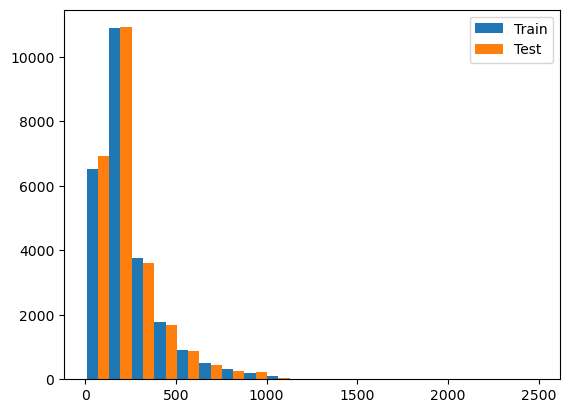

In [9]:
plt.hist([[len(x) for x in text_train], 
          [len(x) for x in text_test]], 
         bins=20, rwidth=1)
plt.legend(("Train", "Test"));

Neuronale Netze erwarten die Eingabedaten für jeden Batch in einem einzigen großen Tensor, nicht als Liste von Listen. Diese Repräsentation ist aber nur möglich, wenn alle Texte im Batch gleich viele Token umfassen. Deshalb müssen zu lange Texte abgeschnitten (`pre` = vorne oder `post` = hinten) und kürzere Texte mit Padding-Token aufgefüllt werden. Dies könnte separate für jeden Batch durchgeführt werden, um die gemeinsame Länge jeweils anzupassen (was besonders sinnvoll ist, wenn die Daten in Batches aus Texten ähnlicher Länge vorgruppiert sind). Der Einfachheit halber führen wir die Anpassung aber als Vorverarbeitung für die kompletten Trainings- und Testdaten durch.

> **Frage:** Was könnte eine sinnvolle Länge sein? Sollten längere Texte vorne oder hinten abgeschnitten werden? Und wo sollte ggf. erforderliches Padding eingefügt werden?

Wir schneiden hier Texte bei 250 Token ab, so dass ein erheblicher Teil der Rezensionen ungekürzt verarbeitet werden kann. Ob vorne oder hinten gekürzt werden sollte ist nicht offensichtlich: es scheint aber üblich, die Gesamteinschätzung gleich am Anfang der Rezension zu vermitteln und sich dann den Einzelheiten zuzuwenden. Daher behalten wir stets den Anfang der Texte.

Klarer ist, wo Padding eingefügt werden sollte: Wir wollen ja ein LSTM anwenden, um Informationen aus den ganzen Texten aufzusammeln und schließlich für die Sentimentanalyse zu nutzen. Würde das Padding hinten eingefügt, so müsste sich das LSTM die gewonnenen Information über alle Padding-Token hinweg merken (während es bei Padding-Token am Anfang der Sequenz einfach in seinem Initialisierungszustand bleiben ann).

In [10]:
X_train = pad_sequences(text_train, maxlen=250, 
                        truncating="post", padding="pre")
X_test = pad_sequences(text_test, maxlen=250, 
                       truncating="post", padding="pre")
X_train.shape

(25000, 250)

`X_train` und `X_test` sind $25000 \times 250$-Matrizen. Wir sehen uns noch einmal die erste Rezension aus den Trainingsdaten mit Padding an.

In [11]:
print(X_train[0, :])
print(decode_sent(X_train[0, :], join=True))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    1  146  685   15 7357   37 1040    4   22  421    4
  359    8  361   38   76 5401   18   57  282 1689  279  198   27  326
    7 1158  108  958    7 1606  715   19 3868  486 1376   11   13  197
  128    7   90    5  104  329    7   90   18   14   20   10   10    2
  116    5   49  388    7  486   17   73   17   49  869  674 1326   26
   51   93   72  202   12  141    6  312  675   10   10   14  238   30
    6 

Solche numerischen Textkodierungen können mit einem [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)-Layer in eine subsymbolische Repräsentation (d.h. in Vektoren $\mathbf{x} \in \mathbb{R}^d$) übersetzt werden.  Ein solcher Embedding-Layer ist vollständig äquivalent zu einem Dense-Layer über Eingabevektoren in One-Hot-Kodierung, kann aber wesentlich effizienter implementiert werden.

### Hilfsfunktionen

Wir übernehmen zwei Hilfsfunktionen aus früheren Übungen. Beachten Sie, dass die oben erstellen Trainings- und Testdaten in `train_and_eval()` als Default-Werte hinterlegt werden.

In [12]:
def history_plot(history, ylim=(0.7, 1.0)):
    plt.figure(figsize=(8, 4))
    xvals = [x + 1 for x in history.epoch]
    plt.plot(xvals, history.history["accuracy"], linewidth=3)
    plt.plot(xvals, history.history["val_accuracy"], linewidth=3)
    plt.axis((1, max(xvals)) + ylim)
    plt.grid(True, axis="y")
    plt.title("Learning curves")
    plt.xlabel("training epoch")
    plt.ylabel("accuracy")
    plt.legend(["Train", "Test"], loc="lower right")

In [13]:
def train_and_eval(inputs, outputs, epochs=10, batch_size=1024, 
                   X=X_train, y=y_train, test_X=X_test, test_y = y_test,
                   verbose=1, plot=False, summary=False):
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    if summary:
        print(model.summary())
    
    res = model.fit(X, y, epochs=epochs, batch_size=batch_size, 
                    verbose=verbose, validation_data=(test_X, test_y))

    test_loss, test_acc = model.evaluate(test_X, test_y, batch_size=batch_size)
    print(f'Test accuracy: {100 * test_acc:.3f}%')

    if plot:
        history_plot(res)
    
    return model

## LSTM auf Word-Embeddings

Das einfachste rekurrente Netzwerk für Textklassifikation besteht aus einem Embedding-Layer, einem rekurrenten [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)-Layer zur Kodierung der kompletten Rezension in einen einzigen Vektor, sowie einem logistischen Layer mit einem einzigen Neuron für die Klassifikationsentscheidung.

Das Format des Eingabe-Layers zeigt an, dass die Textlänge (`None`) nicht vorab festgelegt ist, sondern in jedem Batch unterschiedlich sein kann.

In [14]:
inputs = Input(shape=(None,))

Für den Embedding-Layer müssen wir die Größe $n_w$ des Vokabulars (so viele Vektorrepräsentationen muss der Layer lernen) sowie die Dimensionalität $\mathbb{R}^d$ der Embedding-Vektoren (hier $d = 100$) angeben. Wir haben $n_w$ zwar beim Laden des Datensatzes festgelegt, am sichersten ist es aber, den korrekten Wert hier noch einmal zu ermitteln. Wir geben hier `mask_zero=True` an, damit die Padding-Tokens beim Training des Modells nicht berücksichtigt werden.

In [15]:
n_w = X_train.max() + 1
embeddings = layers.Embedding(n_w, 100, mask_zero=True)

Beim LSTM-Layer muss die Anzahl der Neuronen spezifiziert werden (für Ausgabe und den Hidden State). Zahlreiche weitere Optionen sind in der [Dokumentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) zu finden. Wird für jedes Token eine Ausgabe benötigt (um z.B. weitere LSTM-Layer anzuschließen), so muss auch die Option `return_sequences=True` angegeben werden.

In [16]:
lstm = layers.LSTM(50)

Der Ausgabelayer benötigt nur ein einzelnes Neuron für die binäre Klassifikation _positiv_ vs. _negativ_. Mit einer logistischen Aktivierungsfunktion kann die Ausgabe als Wahrscheinlichkeit der positiven Klasse (1) interpretiert werden.

In [17]:
classifier = layers.Dense(1, activation="sigmoid")

Nun können wir die Layer verketten und so das vollständige neuronale Netz erstellen.

> **Frage:** Der Embedding-Layer umfasst 1 Million Parameter ($n_w = 10000 \times d = 100$). Können Sie erklären, wie die 30,200 Parameter des LSTM-Layer zustandekommen?

In [18]:
outputs = classifier(lstm(embeddings(inputs)))
model = Model(inputs=inputs, outputs=outputs)
model.summary()       

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 1030251 (3.93 MB)
Trainable params: 1030251 (3.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Als Optimierungsverfahren verwenden wir wie immer Adam. Eine geeignete Loss-Funktion ist die [binary cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/binary_crossentropy), welche die durchschnittliche Wahrscheinlichkeit der korrekten Klasse in Bits berechnet.

In [19]:
model.compile(loss="binary_crossentropy", 
              optimizer="Adam", metrics=["accuracy"])

Wir trainieren unser Modell zunächst einmal für 10 Epochen.

> **Frage:** Denken Sie, dass ein längeres Training sinnvoll wäre?

In [20]:
history = model.fit(X_train, y_train, batch_size=1024,
                    epochs=10, verbose=1,
                    validation_data=[X_test, y_test])

Epoch 1/10
25/25 [==============================] - 36s 1s/step - loss: 0.6809 - accuracy: 0.6121 - val_loss: 0.5834 - val_accuracy: 0.7403
Epoch 2/10
25/25 [==============================] - 37s 2s/step - loss: 0.4659 - accuracy: 0.8055 - val_loss: 0.4177 - val_accuracy: 0.8180
Epoch 3/10
25/25 [==============================] - 38s 2s/step - loss: 0.3142 - accuracy: 0.8790 - val_loss: 0.3401 - val_accuracy: 0.8556
Epoch 4/10
25/25 [==============================] - 38s 2s/step - loss: 0.2405 - accuracy: 0.9134 - val_loss: 0.3641 - val_accuracy: 0.8531
Epoch 5/10
25/25 [==============================] - 38s 2s/step - loss: 0.1961 - accuracy: 0.9336 - val_loss: 0.3368 - val_accuracy: 0.8593
Epoch 6/10
25/25 [==============================] - 38s 2s/step - loss: 0.1657 - accuracy: 0.9478 - val_loss: 0.3461 - val_accuracy: 0.8560
Epoch 7/10
25/25 [==============================] - 39s 2s/step - loss: 0.1392 - accuracy: 0.9570 - val_loss: 0.4039 - val_accuracy: 0.8528
Epoch 8/10
25/25 [==

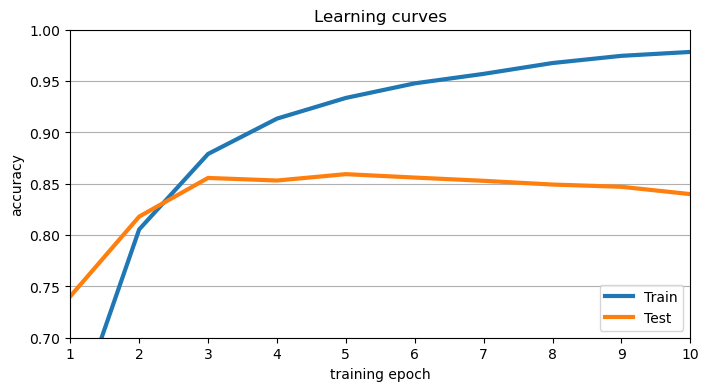

In [21]:
history_plot(history)

## Übung

> Versuchen Sie die Sentimentklassifikation zu verbessern, indem Sie mit unterschiedlichen Netzwerktopologien experimentieren und die Hyperparameter optimieren (z.B. Regularisierung). Können Sie bessere Ergebnisse erzielen als unser erstes LSTM? Oder können Sie ähnliche Ergebnisse mit einem einfacheren Netzwerk erreichen, das schneller trainiert werden kann?
> 
> Sie können beispielsweise folgende Dinge ausprobieren:
>  - Verändern Sie die Größe des LSTM-Layers (d.h. die Anzahl der Neuronen).
>  - Reduzieren Sie die Überanpassung durch Regularisierung, z.B. mit einem Dropout-Layer oder dem internen Dropout des LSTM-Layers.
>  - Verändern Sie die Dimensionalität $d$ der Embeddings und die Vokabulargröße $n_w$. Vielleicht wäre es auch besser, nicht einfach die $n_w$ häufigsten Wörter zu verwenden?
>  - Ist es hilfreich, ein tieferes Netzwerk mit mehr Layern zu verwenden? Sie können dazu sowohl LSTM-Layer als auch herkömmliche Layer stapeln. Wenn Sie herkömmliche Dense-Layer auf Tokenebene verwenden wollen, müssen Sie diese per [TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) über alle Zeitschritte verteilen.
>  - Was passiert, wenn Sie den LSTM-Layer durch ein [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) oder ein [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) ersetzen?  Sie können den rekurrenten Layer natürlich auch [bidirektional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) machen.
>  - Sie könnten auch die Ausgaben des LSTM-Layers aus allen Zeitschritten aufsammeln (z.B. mit [MaxPooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling1D)) statt nur den letzten Zustand zu verwenden (oder zusätzlich dazu). So muss das LSTM vielleicht nicht erst lernen, relevante Informationen bis zum letzten Zeitschritt durchzureichen.
>  - Textklassifikation lässt sich oft auch schon mit einem „bag of words“-Ansatz erstaunlich gut durchführen, braucht also vielleicht gar keine rekurrenten Layer. Können Sie in TensorFlow auch einen „bag of words“ oder „bag of embeddings“ implementieren?
>  - Bei einem „bag of words“-Modell sind oft zusätzlich Bigramme und Trigramme wichtig, um eine gute Klassifikation zu erreichen (z.B. muss _nicht schlecht_ ganz anders gewertet werden als _schlecht_). Versuchen Sie, solche N-Gramme mit Hilfe eines Convolution-Layers ([Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)) zu berücksichtigen.
>  - Vielleicht können Sie auch vortrainierte Word-Embeddings als Initialisierung verwenden, um eine größeres Vokabular abzudecken und unbekannte Wörter in den Testdaten besser verarbeiten zu können? Geeignete FastText-Embeddings mit $d=100$ finden Sie in der Datei `imdb_embeddings.txt`. 

## Lösungsbeispiele

In allen folgenden Beispielen nutzen wir die Hilfsfunktion `train_and_eval()`, um uns Schreibarbeit zu sparen und die Darstellung übersichtlich zu halten. Der Input-Layer bleibt unverändert und kann in allen Beispielen wiederverwendet werden. Alle anderen Layer müssen jeweils komplett neu angelegt werden, um Störeffekte zu vermeiden.

In [22]:
inputs = Input(shape=(250, )) # hier setzen wir die feste Länge der Token-Sequenzen ein

### Regularisierung

Unser erstes LSTM ist bereits hochgradig übertrainiert, was angesichts der großen Anzahl von Parametern nicht überraschend ist. Vielleicht wäre es sinnvoll, die Dimensionalität der Embeddings und/oder des LSTM-Layers zu reduzieren, oder aber ein kleineres Vokabular zu verwenden.

Eine einfache und robuste Regularisierung kann durch Dropout-Layer erreicht werden, die im LSTM-Layer bereits fest eingebaut sind.  Es gibt separate Dropouts für die Eingabeneuronen (`dropout`, entspricht einem Dropout-Layer zwischen Embeddings und LSTM) und für den rekurrenten _cell state_ (`recurrent_dropout`).  Für Input-Layer wird eine Dropout-Wahrscheinlichkeit von 20% empfohlen, für Hidden Layer ein Wert zwischen 20% und 50%.

Epoch 1/10
25/25 [==============================] - 47s 2s/step - loss: 0.6870 - accuracy: 0.5757 - val_loss: 0.6668 - val_accuracy: 0.6637
Epoch 2/10
25/25 [==============================] - 44s 2s/step - loss: 0.5406 - accuracy: 0.7617 - val_loss: 0.4328 - val_accuracy: 0.8097
Epoch 3/10
25/25 [==============================] - 46s 2s/step - loss: 0.3756 - accuracy: 0.8529 - val_loss: 0.3823 - val_accuracy: 0.8392
Epoch 4/10
25/25 [==============================] - 48s 2s/step - loss: 0.2969 - accuracy: 0.8882 - val_loss: 0.3523 - val_accuracy: 0.8582
Epoch 5/10
25/25 [==============================] - 46s 2s/step - loss: 0.2526 - accuracy: 0.9081 - val_loss: 0.3945 - val_accuracy: 0.8536
Epoch 6/10
25/25 [==============================] - 45s 2s/step - loss: 0.2205 - accuracy: 0.9234 - val_loss: 0.4072 - val_accuracy: 0.8559
Epoch 7/10
25/25 [==============================] - 45s 2s/step - loss: 0.1957 - accuracy: 0.9337 - val_loss: 0.4069 - val_accuracy: 0.8574
Epoch 8/10
25/25 [==

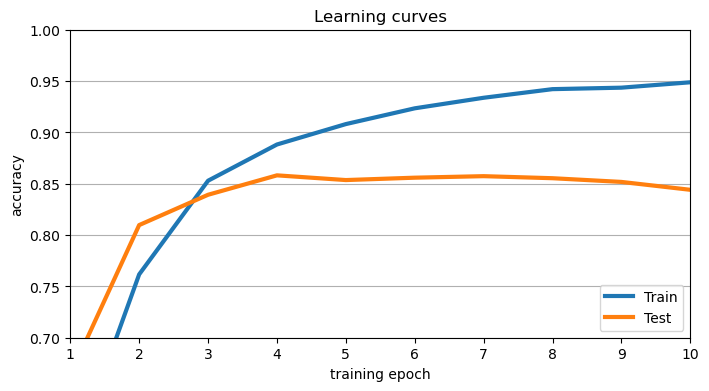

In [23]:
embed = layers.Embedding(n_w, 64, mask_zero=True)
lstm = layers.LSTM(32, dropout=.2, recurrent_dropout=.5)
classifier = layers.Dense(1, activation="sigmoid")

outputs = classifier(lstm(embed(inputs)))
model = train_and_eval(inputs, outputs, plot=True)

Mit diesen Maßnahmen konnte die Überanpassung schon deutlich reduziert werden, aber es zeigt sich immer noch ein langsames Abfallen der Genauigkeit auf den Testdaten. Insgesamt ist das Ergebnis schlechter, als ohne Regularisierung bei Early Stopping nach der dritten oder vierten Epoche möglich gewesen wäre.

Es scheint eigentlich sinnvoller, beim Dropout nicht einzelne Dimensionen der Embeddings zu verrauschen (was der `dropout`-Parameter des LSTM-Layers bewirkt), sondern manche Wörter komplett auszulassen (damit sich das neuronale Netz nicht ganz auf einzelne Wörter in einer Rezension stützen kann). Das geht mit ein [SpatialDropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SpatialDropout1D)-Layer, der eigentlich für CNN gedacht ist und dort vollständige Pixel (mit allen Farb- bzw. Featurekanälen) löscht. Hier lassen wir zufällig jedes zweite Wort im Text aus, verzichten dafür aber auch auf Dropout im _cell state_ des LSTM.

Epoch 1/10
25/25 [==============================] - 30s 1s/step - loss: 0.6869 - accuracy: 0.5880 - val_loss: 0.6665 - val_accuracy: 0.6883
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.5349 - accuracy: 0.7691 - val_loss: 0.4376 - val_accuracy: 0.8091
Epoch 3/10
25/25 [==============================] - 29s 1s/step - loss: 0.3579 - accuracy: 0.8596 - val_loss: 0.3434 - val_accuracy: 0.8563
Epoch 4/10
25/25 [==============================] - 29s 1s/step - loss: 0.2807 - accuracy: 0.8952 - val_loss: 0.3314 - val_accuracy: 0.8640
Epoch 5/10
25/25 [==============================] - 29s 1s/step - loss: 0.2366 - accuracy: 0.9146 - val_loss: 0.3227 - val_accuracy: 0.8662
Epoch 6/10
25/25 [==============================] - 30s 1s/step - loss: 0.2137 - accuracy: 0.9242 - val_loss: 0.3575 - val_accuracy: 0.8614
Epoch 7/10
25/25 [==============================] - 30s 1s/step - loss: 0.1927 - accuracy: 0.9332 - val_loss: 0.3400 - val_accuracy: 0.8648
Epoch 8/10
25/25 [==

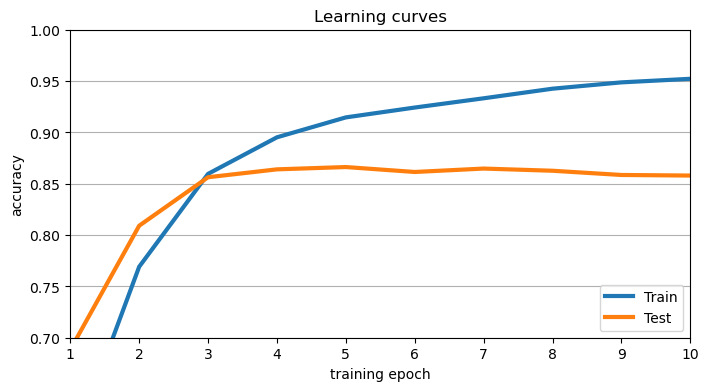

In [24]:
embed = layers.Embedding(n_w, 64, mask_zero=True)
dropout = layers.SpatialDropout1D(.5)
lstm = layers.LSTM(32)
classifier = layers.Dense(1, activation="sigmoid")

outputs = classifier(lstm(dropout(embed(inputs))))
model = train_and_eval(inputs, outputs, plot=True)

Dieser Ansatz bewirkt eine etwas effektivere Regularisierung und die Accuracy auf den Testdaten bleibt über mehrere Epochen hinweg deutlich über 86%.

Eine andere Möglichkeit wäre natürlich, die Vokabulargröße $n_w$ und damit auch die Anzahl der zu trainierenden Parameter zu reduzieren. Dazu ist eine erneute Vorverarbeitung der Trainings- und Testdaten notwendig, um die numerischen IDs anzupassen. Wir können dies am einfachsten mit NumPy-Operationen auf den mittels Padding erstellten Eingabematrizen erreichen und alle IDs über 2000 durch OOV (2) ersetzen.

In [25]:
X_train_2k = X_train.copy()
X_train_2k[X_train_2k >= 2000] = 2
X_test_2k = X_test.copy()
X_test_2k[X_test_2k >= 2000] = 2
print(decode_sent(X_train_2k[0, 100:], join=True)) # mehr OOV als vorher

-PAD- -PAD- -PAD- -PAD- -PAD- -PAD- -PAD- -PAD- -PAD- -PAD- -PAD- -PAD- -PAD- -PAD- -PAD- -START- i'm disappointed that -OOV- who wrote the film felt the need to use so much -OOV- for no reason whatsoever maybe that's his idea of adult films plenty of nasty words with -OOV- humor thrown in i thought better of him and think less of him for this movie br br -OOV- acting and some moments of humor as well as some possibly important themes are what made me give it such a high rating br br this might be a good movie for adult children to watch and laugh over about their own folks and their -OOV- but the lack of -OOV- for audience -OOV- seriously -OOV- what could have been a family film but fails certainly not worth -OOV- money on though it might be worth a watch for free on television


Epoch 1/10
25/25 [==============================] - 37s 1s/step - loss: 0.6850 - accuracy: 0.6012 - val_loss: 0.6559 - val_accuracy: 0.6836
Epoch 2/10
25/25 [==============================] - 35s 1s/step - loss: 0.5330 - accuracy: 0.7587 - val_loss: 0.4565 - val_accuracy: 0.7982
Epoch 3/10
25/25 [==============================] - 35s 1s/step - loss: 0.4054 - accuracy: 0.8304 - val_loss: 0.3802 - val_accuracy: 0.8375
Epoch 4/10
25/25 [==============================] - 35s 1s/step - loss: 0.3571 - accuracy: 0.8545 - val_loss: 0.4237 - val_accuracy: 0.8383
Epoch 5/10
25/25 [==============================] - 35s 1s/step - loss: 0.3330 - accuracy: 0.8681 - val_loss: 0.3418 - val_accuracy: 0.8584
Epoch 6/10
25/25 [==============================] - 35s 1s/step - loss: 0.3105 - accuracy: 0.8794 - val_loss: 0.3790 - val_accuracy: 0.8561
Epoch 7/10
25/25 [==============================] - 35s 1s/step - loss: 0.2965 - accuracy: 0.8854 - val_loss: 0.3623 - val_accuracy: 0.8589
Epoch 8/10
25/25 [==

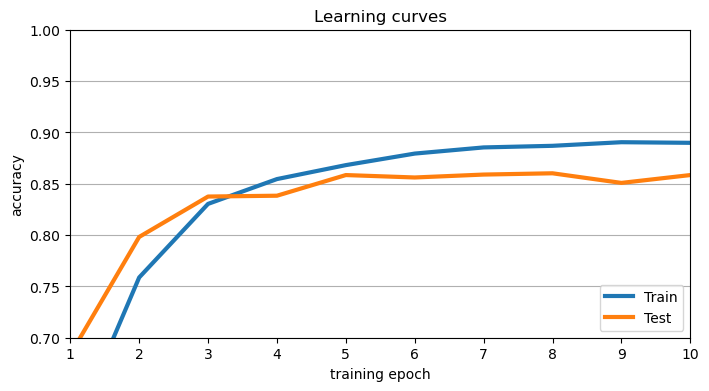

In [26]:
embed = layers.Embedding(2000, 64, mask_zero=True)
lstm = layers.LSTM(32, recurrent_dropout=.5)
classifier = layers.Dense(1, activation="sigmoid")

outputs = classifier(lstm(embed(inputs)))
model = train_and_eval(inputs, outputs, X=X_train_2k, test_X=X_test_2k, plot=True)

Mit dem eingeschränkten Vokabular wird zwar Überanpassung weitgehend verhindert, aber die Ergebnisse auf den Trainingsdaten lassen kaum Spielraum für Verbesserungen. Offensichtlich fehlen nun viele wichtige Sentiment-Ausdrücke.

## Deeper Learning

Unser bisheriges Modell kann kaum als _deep learning_ bezeichnet werden, da es im wesentlich aus dem Embedding-Layer und einem einzelnen LSTM-Layer besteht. Wir versuchen nun, mit einem tieferen Netzwerk bessere Ergebnisse zu erzielen. Als Ausgangspunkt nehmen wir das Modell mit SpatialDropout, da es relativ robust gegen Überanpassung zu sein scheint.

Zusätzliche nicht-rekurrente Layer zwischen Embeddings und LSTM würden keinerlei Sinn machen, da sie als Ausgabe – z.B. bei zwei zusätzlichen Layern – eine Funktion $f(g(\mathbf{e}_k))$ des Embeddings-Vektors zur Lexikon-ID $k$ liefern. Auch wenn $f$ und $g$ nichtlineare Funktionen sind, kann das Ergebnis genausogut auch direkt als Embedding $\mathbf{e}'_k$ gelernt werden.

Stattdessen können wir den sehr simplen Klassifikationslayer (mit lediglich einem Neuron) durch mehrere Dense-Layer ersetzen, so dass hier eine komplexere Entscheidung getroffen werden kann. Zusätzliche LSTM-Layer können kontextsensitive Repräsentationen der einzelnen Wörter lernen, wofür bidirektionale LSTM besonders sinnvoll erscheinen. Die zusätzlichen Layer müssen natürlich `return_sequences=True` verwenden.

Die zunehmende Komplexität des Netzwerks erhöht auch seine Anfälligkeit für Überanpassung, der wir hier durch zahlreichen Dropouts entgegenwirken.

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 250, 64)           640000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 250, 64)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional (Bidirection  (None, 250, 64)           24832     
 al)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 64)                2112

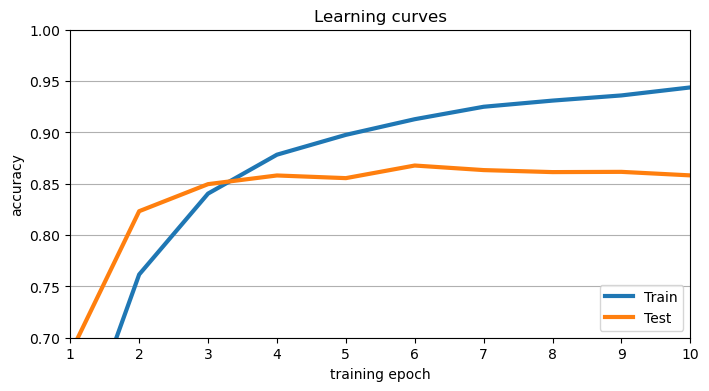

In [27]:
embed = layers.Embedding(n_w, 64, mask_zero=True)
dropout = layers.SpatialDropout1D(.5)
lstm1 = layers.Bidirectional(
    layers.LSTM(32, recurrent_dropout=.5, return_sequences=True))
lstm2 = layers.LSTM(32, dropout=.5, recurrent_dropout=.5)
hidden = layers.Dense(64, activation="relu")
classifier = layers.Dense(1, activation="sigmoid")

outputs = classifier(hidden(lstm2(lstm1(dropout(embed(inputs))))))
model = train_and_eval(inputs, outputs, plot=True, summary=True)

Auch dieses tiefere Netzwerk kann nur minimal bessere Ergebnisse erzielen (bei _early stopping_ im richtigen Moment) und ist zudem sehr anfällig für Überanpassung. Offenbar sind die Trainingsdaten bzw. die zur Verfügung stehenden Oberflächenmerkmale nicht ausreichend, um eine wesentlich bessere Sentiment-Klassifikation zu ermöglichen.

Diese Einschätzung wird von einer [Rangliste der State-of-the-Art-Ergebnisse](https://paperswithcode.com/sota/sentiment-analysis-on-imdb) bestätigt.  Nur spezialiserte Verfahren oder vortrainierte Sprachmodelle können Genauigkeiten über 90% erzielen.

## Neuronale bag-of-words und CNN

Da auch mit tieferen LSTMs keine wesentliche Verbesserung der Genauigkeit über 86% hinaus erreichbar scheint, stellt sich umgekehrt die Frage, ob diese Ergebnisse vielleicht auch mit einfachen _bag of words_-Modellen erreicht werden könnten.

Ein echter BoW-Klassifikator ließe sich z.B. durch one-hot-Kodierung der Eingabewörter und einen [GlobalAveragePooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)-Layer erreichen (oder [GlobalMaxPooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPooling1D) für ein _set of words_). Analog können wir so zusammen mit einem Embedding-Layer ein _bag of embeddings_-Modell definieren.

Epoch 1/10
98/98 [==============================] - 1s 12ms/step - loss: 0.6837 - accuracy: 0.6027 - val_loss: 0.6581 - val_accuracy: 0.7657
Epoch 2/10
98/98 [==============================] - 1s 12ms/step - loss: 0.5945 - accuracy: 0.7626 - val_loss: 0.5029 - val_accuracy: 0.8298
Epoch 3/10
98/98 [==============================] - 1s 12ms/step - loss: 0.4455 - accuracy: 0.8316 - val_loss: 0.3781 - val_accuracy: 0.8536
Epoch 4/10
98/98 [==============================] - 1s 12ms/step - loss: 0.3576 - accuracy: 0.8636 - val_loss: 0.3313 - val_accuracy: 0.8636
Epoch 5/10
98/98 [==============================] - 1s 11ms/step - loss: 0.3163 - accuracy: 0.8802 - val_loss: 0.3107 - val_accuracy: 0.8701
Epoch 6/10
98/98 [==============================] - 1s 11ms/step - loss: 0.2872 - accuracy: 0.8948 - val_loss: 0.3012 - val_accuracy: 0.8736
Epoch 7/10
98/98 [==============================] - 1s 12ms/step - loss: 0.2673 - accuracy: 0.9019 - val_loss: 0.2972 - val_accuracy: 0.8751
Epoch 8/10
98

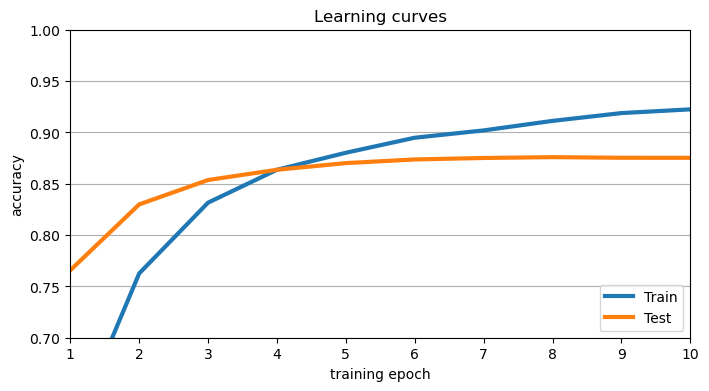

In [28]:
embed = layers.Embedding(n_w, 64, mask_zero=True)
pool = layers.GlobalAveragePooling1D()
drop1 = layers.Dropout(.8)
hidden = layers.Dense(16, activation="relu")
drop2 = layers.Dropout(.5)
classifier = layers.Dense(1, activation="sigmoid")

outputs = classifier(drop2(hidden(drop1(pool(embed(inputs))))))
model = train_and_eval(inputs, outputs, plot=True, batch_size=256)

Dieses Modell erzielt etwas bessere Ergebnisse als alle getesteten LSTM-Klassifikatoren und ist zugleich deutlich robuster gegenüber Overfitting!

Für die Sentiment-Analyse mit BoW-Modellen werden meist auch N-Gramme als Merkmale berücksichtigt. Dies sollten wir im neuronalen Netz mit einem [Convolution](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)-Layer simulieren können, wobei die Größe der N-Gramme durch den Kernel festgelegt wird. Anschließend wird die N-Gramm-Information wieder mit einem Pooling-Layer aufgesammelt.

Das CNN ist wieder anfälliger für Überanpassung und muss durch relativ starke Dropouts regularisiert werden.

Epoch 1/10
98/98 [==============================] - 2s 20ms/step - loss: 0.6839 - accuracy: 0.5827 - val_loss: 0.6571 - val_accuracy: 0.7392
Epoch 2/10
98/98 [==============================] - 2s 20ms/step - loss: 0.5685 - accuracy: 0.7660 - val_loss: 0.4556 - val_accuracy: 0.8296
Epoch 3/10
98/98 [==============================] - 2s 20ms/step - loss: 0.4032 - accuracy: 0.8516 - val_loss: 0.3524 - val_accuracy: 0.8576
Epoch 4/10
98/98 [==============================] - 2s 19ms/step - loss: 0.3333 - accuracy: 0.8779 - val_loss: 0.3219 - val_accuracy: 0.8664
Epoch 5/10
98/98 [==============================] - 2s 20ms/step - loss: 0.2923 - accuracy: 0.8963 - val_loss: 0.3102 - val_accuracy: 0.8733
Epoch 6/10
98/98 [==============================] - 2s 20ms/step - loss: 0.2640 - accuracy: 0.9061 - val_loss: 0.3125 - val_accuracy: 0.8738
Epoch 7/10
98/98 [==============================] - 2s 20ms/step - loss: 0.2421 - accuracy: 0.9132 - val_loss: 0.3171 - val_accuracy: 0.8721
Epoch 8/10
98

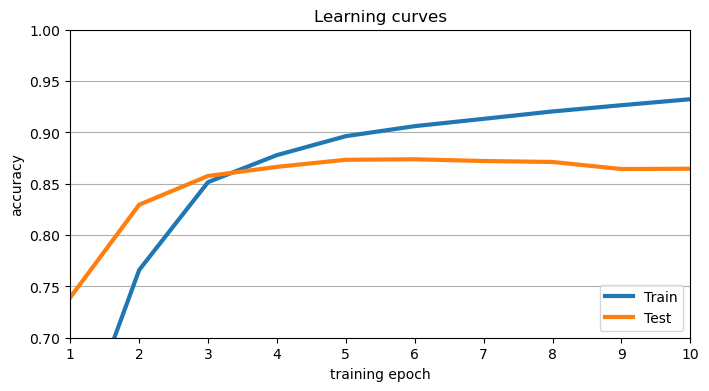

In [29]:
embed = layers.Embedding(n_w, 64, mask_zero=True)
word_drop = layers.SpatialDropout1D(.5)
conv = layers.Conv1D(16, kernel_size=3)
pool = layers.GlobalAveragePooling1D()
drop = layers.Dropout(.8)
classifier = layers.Dense(1, activation="sigmoid")

outputs = classifier(drop(pool(conv(word_drop(embed(inputs))))))
model = train_and_eval(inputs, outputs, plot=True, batch_size=256)

Unser CNN kann zwar im Prinzip Bi- und Trigramme berücksichtigen, muss aber zugleich lernen, die Information relevanter Einzelwörter weiterzuleiten. Es könnte daher sinnvoll sein, ein neuronales Netz mit 2 Pfaden zu definieren: (a) ein reines BoW-Modell und (b) ein CNN für Bi- und Trigramme.

Epoch 1/10
98/98 [==============================] - 3s 23ms/step - loss: 0.6821 - accuracy: 0.5865 - val_loss: 0.6465 - val_accuracy: 0.7617
Epoch 2/10
98/98 [==============================] - 2s 25ms/step - loss: 0.5399 - accuracy: 0.7869 - val_loss: 0.4138 - val_accuracy: 0.8422
Epoch 3/10
98/98 [==============================] - 2s 24ms/step - loss: 0.3668 - accuracy: 0.8646 - val_loss: 0.3283 - val_accuracy: 0.8624
Epoch 4/10
98/98 [==============================] - 3s 28ms/step - loss: 0.2967 - accuracy: 0.8930 - val_loss: 0.3067 - val_accuracy: 0.8713
Epoch 5/10
98/98 [==============================] - 3s 29ms/step - loss: 0.2592 - accuracy: 0.9092 - val_loss: 0.3015 - val_accuracy: 0.8742
Epoch 6/10
98/98 [==============================] - 3s 27ms/step - loss: 0.2324 - accuracy: 0.9211 - val_loss: 0.3054 - val_accuracy: 0.8751
Epoch 7/10
98/98 [==============================] - 3s 27ms/step - loss: 0.2128 - accuracy: 0.9301 - val_loss: 0.3186 - val_accuracy: 0.8719
Epoch 8/10
98

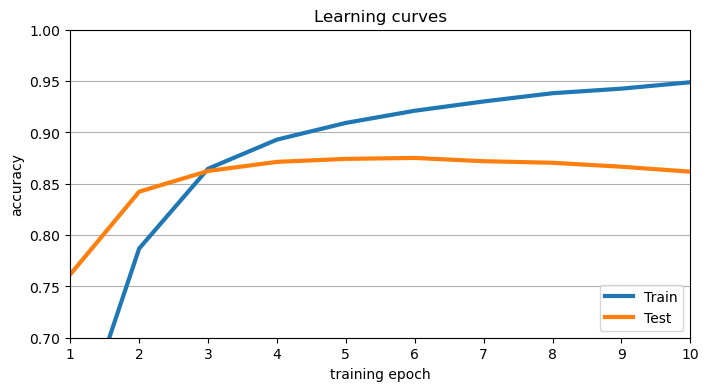

In [42]:
embed = layers.Embedding(n_w, 64, mask_zero=True)
word_drop = layers.SpatialDropout1D(.5)
tokens = word_drop(embed(inputs))

pool1 = layers.GlobalAveragePooling1D()
hidden1 = layers.Dense(16, activation="relu")
path1 = hidden1(pool1(tokens))

conv = layers.Conv1D(16, kernel_size=3)
pool2 = layers.GlobalAveragePooling1D()
path2 = pool2(conv(tokens))


concat = layers.Concatenate()
drop = layers.Dropout(.8)
classifier = layers.Dense(1, activation="sigmoid")
outputs = classifier(drop(concat([path1, path2])))

model = train_and_eval(inputs, outputs, plot=True, batch_size=256)

Auch mit diesem CNN können wir keine Verbesserung gegenüber dem _bag of embeddings_ erreichen. Können Sie die Struktur des Netzwerks in der untenstehenden Layer-Übersicht wiedererkennen? 

In [43]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding_11 (Embedding)    (None, 250, 64)              640000    ['input_2[0][0]']             
                                                                                                  
 spatial_dropout1d_6 (Spati  (None, 250, 64)              0         ['embedding_11[0][0]']        
 alDropout1D)                                                                                     
                                                                                                  
 global_average_pooling1d_8  (None, 64)                   0         ['spatial_dropout1d_6[0

## Vortrainierte Embeddings

Wie bei vielen computerlinguistische Aufgabenstellungen wird das Training unserer Modelle durch den _lexical bottleneck_ erschwert: die 640.000 Parameter des Embedding-Layer können kaum zuverlässig aus nur 25.000 Trainingstexten gelernt werden. In den letzten Jahren hat es sich in diesem Zusammenhang als besonders erfolgreich erwiesen, auf sehr großen Korpora vortrainierte Embeddings (bzw. Sprachmodelle) als Ausgangspunkt zu verwenden, die bereits umfangreiches lexikalisches Wissen zu einem großen Vokabular enthalten. Unser neuronales Netz muss dann nur noch lernen, die relevanten Informationen aus den vortrainierten Embeddings zu extrahieren.

Als Beispiel haben wir vortrainierte FastText-Embeddings (mit $d=300$ Dimensionen) für die 10.000 häufigsten Wortformen aus dem IMDb-Datensatz bereitgestellt in der komprimierten Datei `imdb_embeddings.txt.gz`. Jede Zeile besteht aus einer Wortform gefolgt von einem 300-dimensionalen Vektor.  Das Vokabular für die Embeddings haben wir folgendermaßen ermittelt:

In [32]:
if False:
    import re
    with open("fasttext/imdb_words.txt", "w") as fh:
        for i in range(4, n_w):
            w = id2word[i]
            if re.fullmatch(r'[\x21-\x7f]+', w):
                print(w, file=fh)
            else:
                print(f"skip: id = {i:4d} [{w}]")

Um die vortrainierten Embeddings verwenden zu können, müssen wir zunächst einen geeigneten Embedding-Layer erstellen und initialisieren. Die Initialisierung geschieht erst, wenn wir ihn in ein neuronales Netz integrieren (per Funktionsanwendung, hier mit `embed(inputs)`). Danach können wir die zufällig initialisierten Embeddings als $10000\times 300$-Matrix extrahieren. Die Methode `get_weights()` liefert eine Liste aller Parameter-Tensoren zurück, die hier nur aus der Embedding-Matrix besteht.

In [45]:
embed = layers.Embedding(n_w, 300, mask_zero=True)
tokens = embed(inputs)
M, = embed.get_weights()
M.shape

(10000, 300)

Nun können wir die vortrainierten Embedding-Vektoren einlesen und in passende Zeilen der Matrix `M` einfügen. Kommt eine Wortform nicht in unserem Vokabular vor, so wird sie einfach übersprungen. Wortformen, für die kein vortrainiertes Embedding vorliegt, behalten ihre zufällige Initialisierung.

In [46]:
import gzip
n = 0
with gzip.open("imdb_embeddings.txt.gz", mode="rt") as fh:
    for line in fh.readlines():
        line = line.strip()
        fields = line.split()
        id = word2id.get(fields[0], 2) # 2 = -OOV-
        if id >= 4 and id < n_w:
            M[id, :] = fields[1:]
            n += 1
print("Inserted {:d} pre-trained embedding vectors.".format(n))

Inserted 9986 pre-trained embedding vectors.


Nicht vergessen: die Embeddings müssen jetzt wieder in den Layer eingefügt werden!

In [47]:
embed.set_weights([M])

Um diese Embeddings in unveränderter Form verwenden zu können, müssen wir den Layer statisch machen, indem wir `trainable=False` setzen (was auch schon bei der Erstellung des Layers möglich gewesen wäre). Dadurch werden in den folgenden Experimenten nur die Gewichte der anderen Layer trainiert, die Embeddings selbst bleiben konstant.

In [48]:
embed.trainable = False

Ein direkter _bag of embeddings_-Ansatz macht hier wenig Sinn, da durch die Mittelwertbildung über alle Token viel zu viel Information verloren ginge. Wir müssen zunächst mit Hilfe eines Adapter-Layers die Embeddings so transformieren, dass die sentiment-relevante Information herausgezogen wird. Ein linearer Adapter-Layer könnte zwar durchaus sinnvoll sein (Rothe & Schütze 2016), eine nichtlineare Transformation erweist sich aber als effektiver. Der Adapter-Layer wird per [TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) auf alle Token eines Textes angewendet.

Die Layer-Übersicht zeigt, dass unser Modell zwar über 3 Millionen Parameter hat, von denen aber nur 42.689 tatsächlich trainiert werden. Es sollte also keine drastische Überanpassung zu erwarten sein. Leider lernt dieses Modell sehr langsam, so dass wir die Geduld für über 100 Epochen aufbringen müssen (am besten vor einer Kaffeepause starten!).

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_12 (Embedding)    (None, 250, 300)          3000000   
                                                                 
 time_distributed_2 (TimeDi  (None, 250, 128)          38528     
 stributed)                                                      
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
 1 (GlobalAveragePooling1D)                                      
                                                                 
 dense_23 (Dense)            (None, 32)                4128      
                                                                 
 dense_24 (Dense)            (None, 1)                 33 

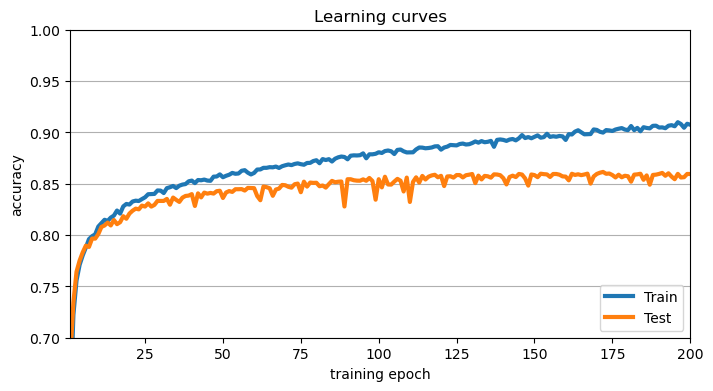

In [49]:
%%time
adapt = layers.TimeDistributed(layers.Dense(128, activation="relu"))
pool = layers.GlobalAveragePooling1D()
hidden = layers.Dense(32, activation="relu")
classifier = layers.Dense(1, activation="sigmoid")

outputs = classifier(hidden(pool(adapt(tokens))))
model = train_and_eval(inputs, outputs, plot=True, batch_size=256, 
                       verbose=0, epochs=200, summary=True)

Dieses Modell kann mit relativ wenigen Parametern schließlich eine Genauigkeit von immerhin knapp 86% erzielen und ist auch ohne Regularisierung kaum übertrainiert. Andere Topologien (mit einem LSTM oder CNN) bringen aber keine deutliche Verbesserung der Lernergebnisse, so dass die Verwendung der vortrainierten Embeddings offenbar hier keine Vorteile bietet.

Besonders gute Erfolge wurden in der Literatur insbesondere durch Fine-Tuning vortrainierter Embeddings bzw. Sprachmodelle erreicht. Dabei bleibt das vortrainierte Modell nicht konstant, sondern kann sich beim Training an Aufgabenstellung und Datensatz anpassen. Wir könnten im Prinzip nun einfach `embed.trainable=True` setzen, müssten dann aber die vortrainierten Embeddings für jeden Trainings-Durchlauf erneut einlesen. Stattdessen legen wir für das Fine-Tuning einen neuen, nicht statischen Layer an (der auch durch integration in ein neuronales Netz initialisert werden muss).

In [50]:
train_embed = layers.Embedding(n_w, 300, mask_zero=True)
word_drop = layers.SpatialDropout1D(.5)
pool = layers.GlobalAveragePooling1D()
hidden = layers.Dense(32, activation="relu")
drop = layers.Dropout(.8)
classifier = layers.Dense(1, activation="sigmoid")

outputs = classifier(hidden(drop(pool(word_drop(train_embed(inputs))))))

Jetzt können wir die zufällig initialisierte Matrix des Layers einfach durch die vortrainierten Embeddings ersetzen:

In [51]:
train_embed.set_weights(embed.get_weights())

Dieses Modell erzielt mit entsprechend starker Regularisierung (da jetzt über 3 Millionen Parameter trainiert werden) recht gute und robuste Ergebnisse. Es sollte durch die vortrainierten Embeddings als Ausgangspunkt auch relativ schnell und effektiv lernen können.

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_13 (Embedding)    (None, 250, 300)          3000000   
                                                                 
 spatial_dropout1d_7 (Spati  (None, 250, 300)          0         
 alDropout1D)                                                    
                                                                 
 global_average_pooling1d_1  (None, 300)               0         
 2 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_7 (Dropout)         (None, 300)               0         
                                                                 
 dense_25 (Dense)            (None, 32)                963

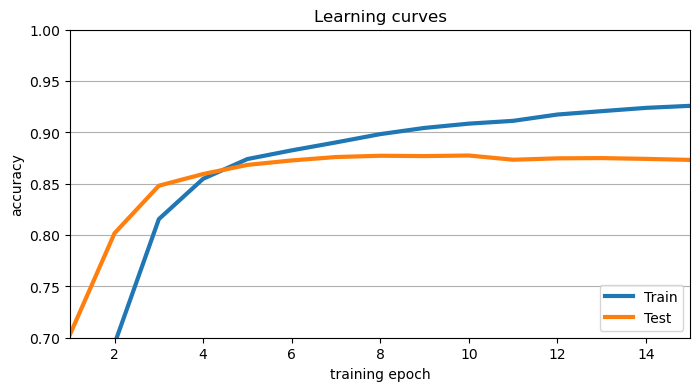

In [52]:
model = train_and_eval(inputs, outputs, batch_size=256, epochs=15, plot=True, summary=True)